# 计算真实数据的滚动R0

In [41]:
import pandas as pd
import numpy as np

data_folder = 'datasets/'
suffix = 'cases_0412_1231.csv'
state_list = ['arizona', 'mississippi', 'new mexico', 'texas', 'virginia']
data_paths = {state: data_folder + state + '_' + suffix for state in state_list}
data_dict = {state: pd.read_csv(path) for state, path in data_paths.items()}
pop_list = {state: data_dict[state]['Population'].iloc[0] for state in state_list}
pop_list


{'arizona': 7278717,
 'mississippi': 2976149,
 'new mexico': 2096829,
 'texas': 28995881,
 'virginia': 8535519}

In [42]:
import numpy as np
from scipy.stats import gamma
from scipy.stats import gamma as gamma_dist

def estimate_Rt(gt_df, cols=['Q_gt', 'D_gt', 'R_gt'], window=21, pop = 100000, eps = 1e-12):
    gt_df = gt_df.copy()
    gt_df['Confirmed'] = gt_df[cols].sum(axis=1)
    gt_df['new_cases'] = gt_df['Confirmed'].diff().fillna(0)
    gt_df.loc[gt_df['new_cases'] < 0, 'new_cases'] = 0  # 修正负值
    # 计算每10万人发病率
    gt_df['incidence_rate'] = gt_df['new_cases'] / pop * 100000
    gt_df['incidence_rate_7d'] = gt_df['incidence_rate'].rolling(window=7, min_periods=1).mean()
    # 设定代际时间分布参数
    mean_si, sd_si = 5, 2   ##从感染者发病，到其传染的下一代人发病的时间间隔
    shape = (mean_si / sd_si)**2
    scale = (sd_si**2) / mean_si
    # 离散化 1-20 天
    w = [gamma.cdf(s+1, a=shape, scale=scale) - gamma.cdf(s, a=shape, scale=scale)
        for s in range(20)]
    w = np.array(w)
    w /= w.sum()
    a, b = 1, 1   # Gamma先验
    I = gt_df['new_cases'].to_numpy()
    Rt_mean, Rt_low, Rt_high = [], [], []
    dates = []
    for t in range(window, len(I)):
        Lambda = []
        for u in range(t-window, t):
            lam = sum(I[u-(s+1)] * w[s] for s in range(len(w)) if u-(s+1) >= 0)
            Lambda.append(lam)
        I_sum = I[t-window:t].sum()
        Lambda_sum = np.sum(Lambda)
        # 后验参数
        shape_post = a + I_sum
        rate_post  = b + max(Lambda_sum, eps)
        # 点估计和区间
        mean_R = shape_post / rate_post
        ci_low, ci_high = gamma_dist.ppf([0.025, 0.975], shape_post, scale=1/rate_post)
        Rt_mean.append(mean_R)
        Rt_low.append(ci_low)
        Rt_high.append(ci_high)
        dates.append(t)
    rt_df = pd.DataFrame({
        't': dates,
        'R_mean': Rt_mean,
        'R_low': Rt_low,
        'R_high': Rt_high
    })
    return rt_df, gt_df['incidence_rate_7d']


In [73]:
# Plot for R0, incidence rate
from datetime import date
import matplotlib.pyplot as plt
def plot_Rt_and_incidence(rt_df, ra_df, rt_incidence, ra_incidence,date, delta_window, output_folder = None, state = 'state', base_results = None):
   '''tr_df: ground truth R_t dataframe
       ra_df: agent R_t dataframe
       rt_incidence: ground truth incidence rate series
       ra_incidence: agent incidence rate series'''
   plt.figure(figsize=(12, 6))
   plt.plot(date, rt_df['R_mean'], label='Ground Truth', color='blue')
   plt.fill_between(date, rt_df['R_low'], rt_df['R_high'], color='blue', alpha=0.2)
   plt.plot(date, ra_df['R_mean'], label='Agent Policy', color='green')
   plt.fill_between(date, ra_df['R_low'], ra_df['R_high'], color='green', alpha=0.2)
   if base_results:
      base_df, _ = base_results
      plt.plot(date, base_df['R_mean'], label='Agent Policy (base)', color='orange', linestyle='--')
      plt.fill_between(date, base_df['R_low'], base_df['R_high'], color='orange', alpha=0.2)
   plt.axhline(1, color='red', linestyle='--', label='R=1 Threshold')
   plt.xlabel('Time (t)', fontsize=20)
   plt.ylabel('R(t)', fontsize=20)
   plt.xticks(fontsize=16)
   plt.yticks(fontsize=16)
   plt.title('Effective Reproduction Number (R_t) Over Time for ' + state.title())
   plt.legend(fontsize=16)
   plt.grid()
   plt.tight_layout()
   if output_folder:
      plt.savefig(f"{output_folder}/{state.replace(' ', '_')}_R0.png")
   plt.show()

   plt.figure(figsize=(12,6))
   # date = pd.date_range(start=start_day, periods=len(gt_df))
   plt.plot(date, rt_incidence[delta_window:], label='Ground Truth', color='#1f77b4', linewidth=2.2)
   plt.plot(date, ra_incidence[delta_window:], label='Agent Policy', color='#2ca02c', linewidth=2.2, linestyle='--')
   if base_results:
      _, base_incidence = base_results
      plt.plot(date, base_incidence[delta_window:], label='Agent Policy (base)', color='#ff7f0e', linewidth=2.2, linestyle='--')
   # 标签
   plt.xlabel('Time (days)', fontsize=20)
   plt.ylabel('Incidence Rate (per 100k)', fontsize=20)
   # 图例
   plt.legend(frameon=False, fontsize=16, loc='upper left')
   plt.xticks(fontsize=16)
   plt.yticks(fontsize=16)
   ax = plt.gca()
   plt.grid(alpha=0.3)
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   plt.tight_layout()
   if output_folder:
      plt.savefig(f"{output_folder}/{state.replace(' ', '_')}_incidence.png")
   plt.show()  
   return 

def plot_active_cases(gt_df, agent_df, date, delta_window, output_folder = None, state = 'state', base_results = None):
   plt.figure(figsize=(12, 6))
   gt_df['active_case_ratio'] = gt_df['Q_gt'] / pop_list[state] *100000
   agent_df['active_case_ratio'] = agent_df['Q_pred'] / pop_list[state] * 100000
   # 绘制 gt_df 的 active_case_ratio
   plt.plot(date, gt_df['active_case_ratio'][delta_window:], label='Ground Truth', color='blue', linewidth=2)
   # 绘制 agent_df 的 active_case_ratio
   plt.plot(date, agent_df['active_case_ratio'][delta_window:], label='Agent Policy', color='green', linestyle='--', linewidth=2)
   if base_results:
      base_df, _ = base_results
      base_df['active_case_ratio'] = base_df['Q_pred'] / pop_list[state] * 100000
      plt.plot(date, base_df['active_case_ratio'][delta_window:], label='Agent Policy (base)', color='orange', linestyle='--', linewidth=2)
   # 添加图例、标题和标签
   plt.xlabel('Time (days)', fontsize=20)
   plt.ylabel('Active case ratio (per 100K)', fontsize=20)
   plt.title('Active Case Ratio of ' + state + ' Over Time', fontsize=22)
   plt.legend(fontsize=16, frameon=False)
   plt.xticks(fontsize=16)
   plt.yticks(fontsize=16)
   # 美化图表
   plt.grid(alpha=0.3)
   ax = plt.gca()
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   # 显示图表
   plt.tight_layout()
   if output_folder:
      plt.savefig(f"{output_folder}/{state.replace(' ', '_')}_active_cases.png")
   plt.show()
   return gt_df, agent_df

def plot_death_cases(gt_df, agent_df, date, delta_window, output_folder = None, state = 'state', base_results = None):
   gt_df['new_deaths'] = gt_df['D_gt'].diff().clip(lower=0)
   gt_df['death_incidence_per100k'] = gt_df['new_deaths'] / pop_list[state] * 100_000
   gt_df['death_incidence_7d'] = gt_df['death_incidence_per100k'].rolling(7, min_periods=1).mean()

   agent_df['new_deaths'] = agent_df['D_pred'].diff().clip(lower=0)
   agent_df['death_incidence_per100k'] = agent_df['new_deaths'] / pop_list[state] * 100000
   agent_df['death_incidence_7d'] = agent_df['death_incidence_per100k'].rolling(7, min_periods=1).mean()
   # 绘制 gt_df 的 death_case_ratio
   plt.figure(figsize=(12, 6))
   plt.plot(date, gt_df['death_incidence_7d'][delta_window:], label='Ground Truth', color='blue', linewidth=2)
   # 绘制 agent_df 的 death_case_ratio
   plt.plot(date, agent_df['death_incidence_7d'][delta_window:], label='Agent Policy', color='green', linestyle='--', linewidth=2)
   if base_results:  
      base_df, _ = base_results
      base_df['new_deaths'] = base_df['D_pred'].diff().clip(lower=0)
      base_df['death_incidence_per100k'] = base_df['new_deaths'] / pop_list[state] * 100000
      base_df['death_incidence_7d'] = base_df['death_incidence_per100k'].rolling(7, min_periods=1).mean()
      plt.plot(date, base_df['death_incidence_7d'][delta_window:], label='Agent Policy (base)', color='orange', linestyle='--', linewidth=2)
   # 添加图例、标题和标签
   plt.xlabel('Time (days)', fontsize=20)
   plt.ylabel('Daily Death Incidence (per 100K)', fontsize=20)
   plt.title('Daily Death Incidence of ' + state + ' Over Time', fontsize=22)
   plt.legend(fontsize=16, frameon=False)
   plt.xticks(fontsize=16)
   plt.yticks(fontsize=16)
   # 美化图表
   plt.grid(alpha=0.3)
   ax = plt.gca()
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   # 显示图表
   plt.tight_layout()
   if output_folder:
      plt.savefig(f"{output_folder}/{state.replace(' ', '_')}_death_case_ratio.png")
   plt.show()
   return gt_df, agent_df

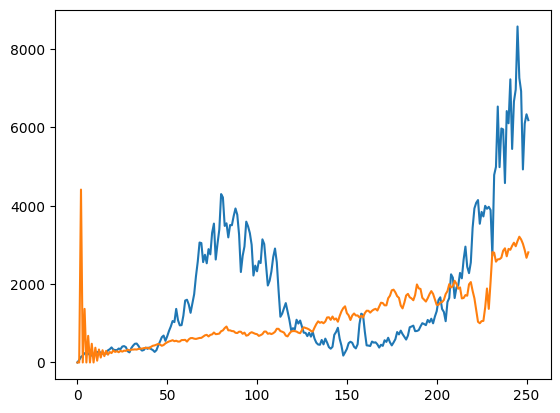

In [44]:
data_folder = 'outputs/baseline/results/'
suffix = 'results.csv'
data_paths = {state: f"{data_folder}{state.replace(' ', '_')}_{suffix}" for state in state_list}
state = state_list[0]
data_path = data_paths[state]
gt_df = pd.read_csv(data_path)
cols = ['Q_gt', 'D_gt', 'R_gt']
output_folder = "D:\\Code\\OD-COVID\\figures\\R0\\"
delta_window = 50
rt_df, rt_incidence = estimate_Rt(gt_df, cols = cols, window=delta_window, pop = pop_list[state])
### read policy data for plotting
results_path='outputs\\gpt-3.5-turbo-0125_2025-10-29-19-28-51\\results'
agent_df = pd.read_csv(f"{results_path}\\{state.replace(' ', '_')}_results.csv")
ra_df, ra_incidence = estimate_Rt(agent_df, cols = ['Q_pred', 'D_pred', 'R_pred'], window=delta_window, pop=pop_list[state])
gt_df['Confirmed'] = gt_df[['Q_gt','R_gt','D_gt']].sum(axis=1)
gt_df['new_cases'] = gt_df['Confirmed'].diff().fillna(0)
gt_df.loc[gt_df['new_cases'] < 0, 'new_cases'] = 0  # 修正负值
agent_df['Confirmed'] = gt_df[['Q_pred','R_pred','D_pred']].sum(axis=1)
agent_df['new_cases'] = agent_df['Confirmed'].diff().fillna(0)
agent_df.loc[agent_df['new_cases'] < 0, 'new_cases'] = 0
plt.plot(gt_df['new_cases'])
plt.plot(agent_df['new_cases'])

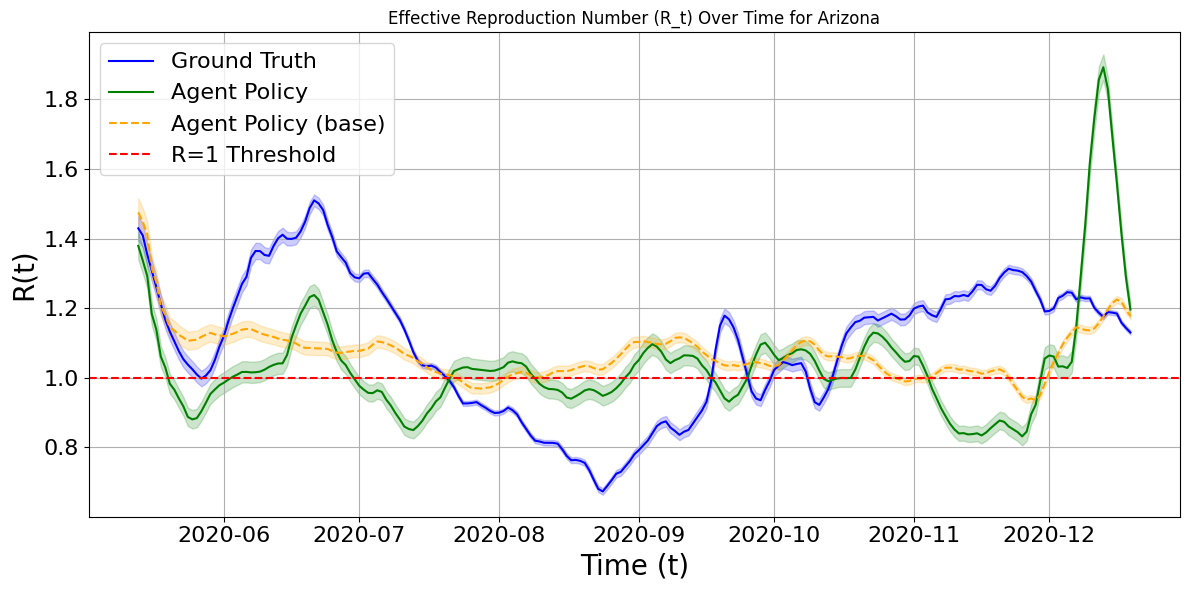

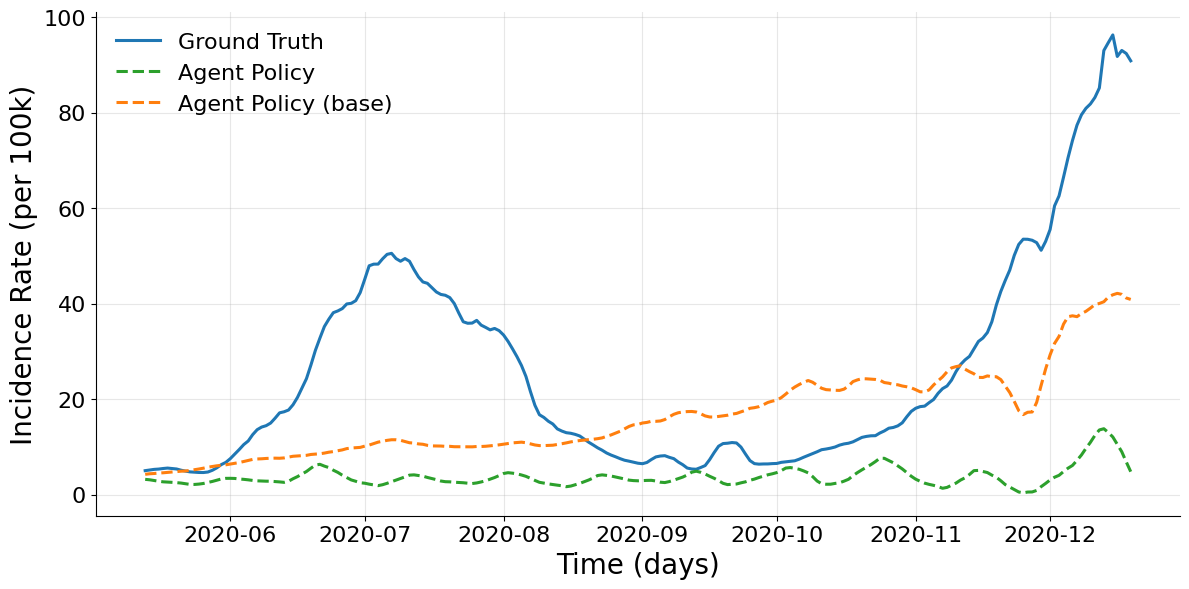

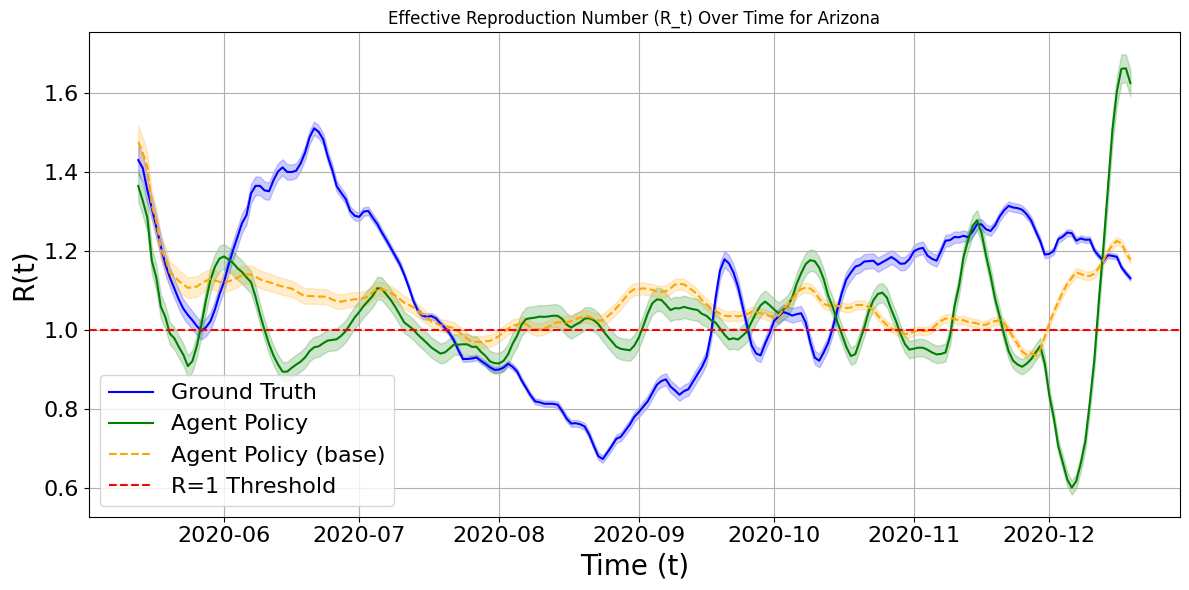

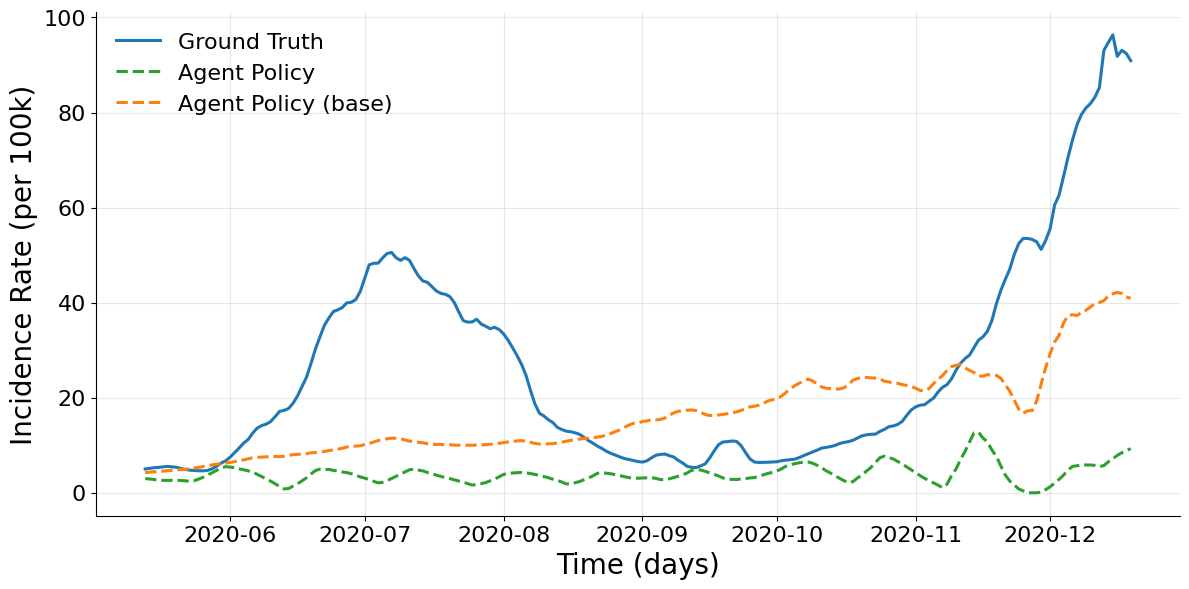

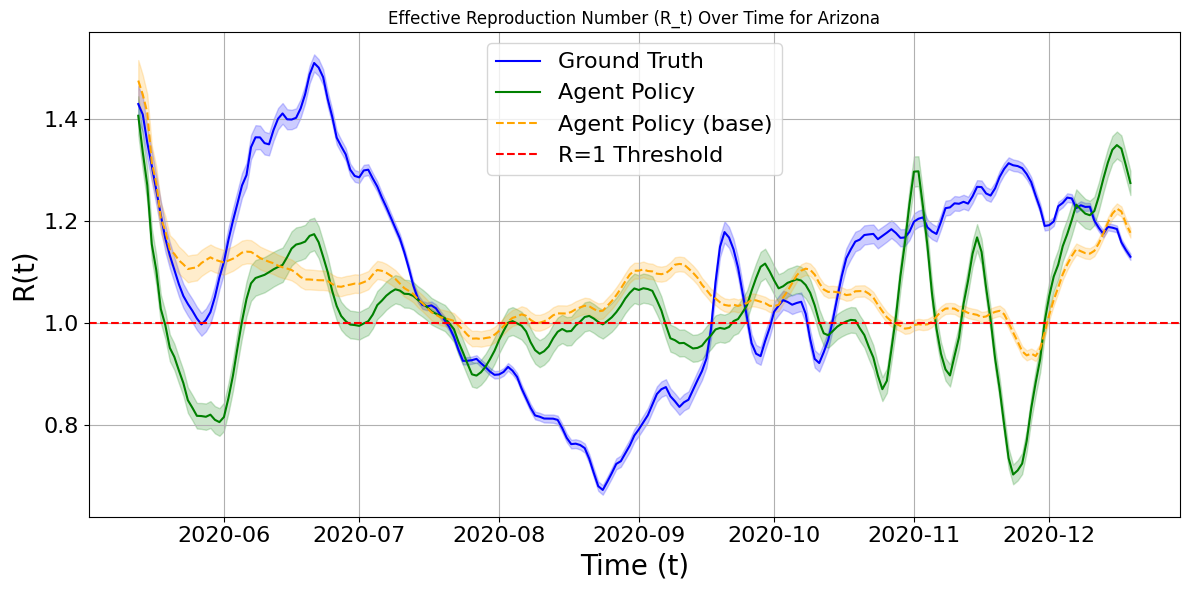

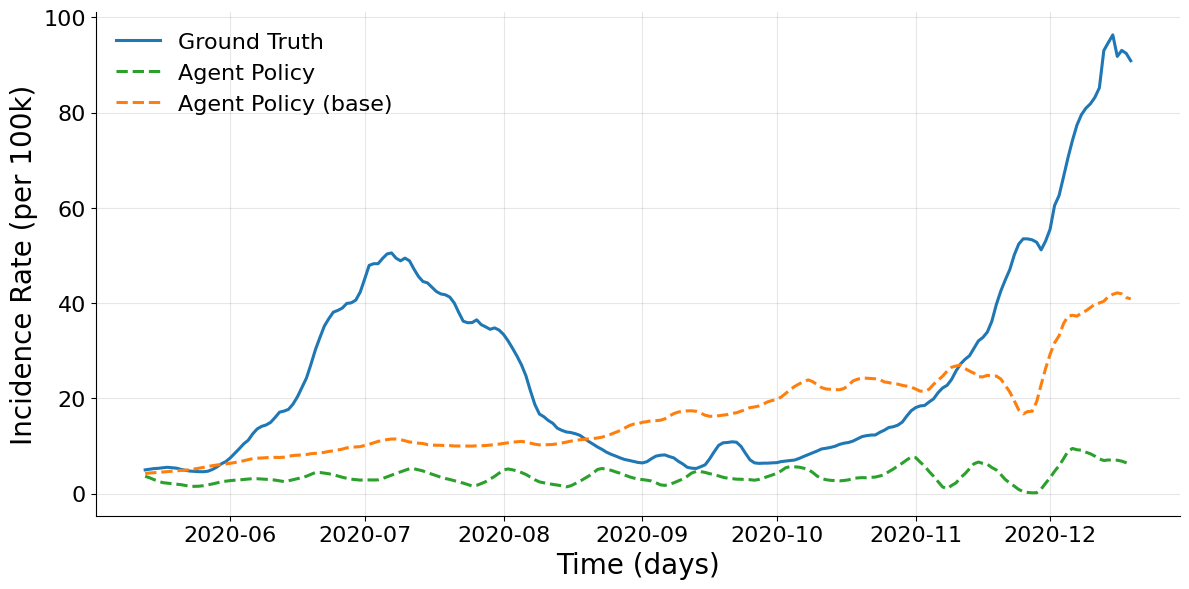

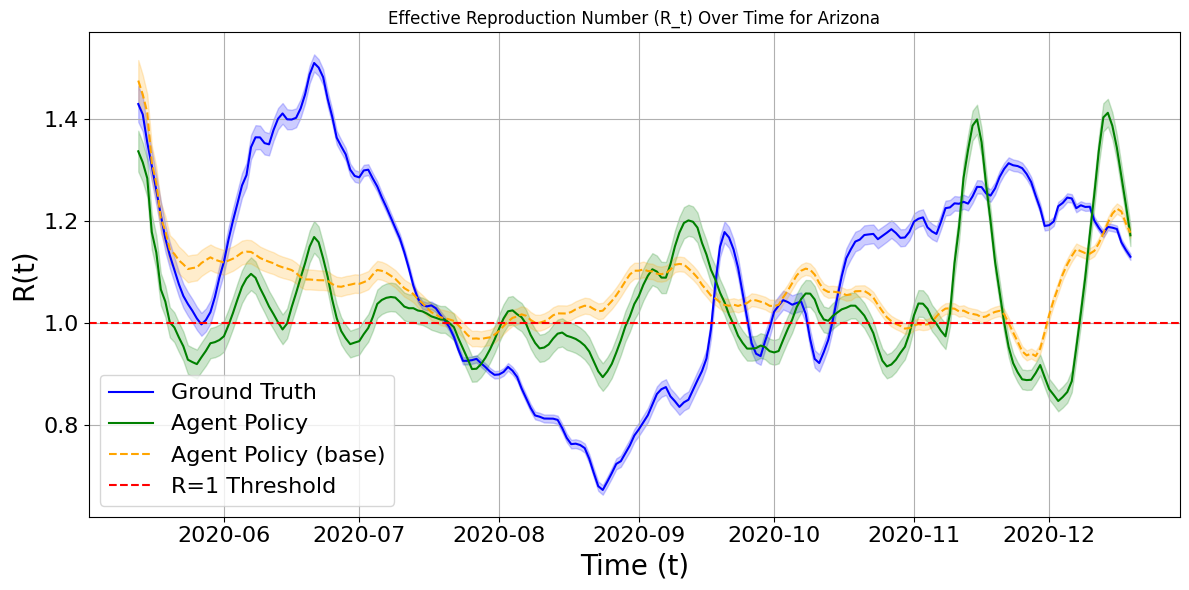

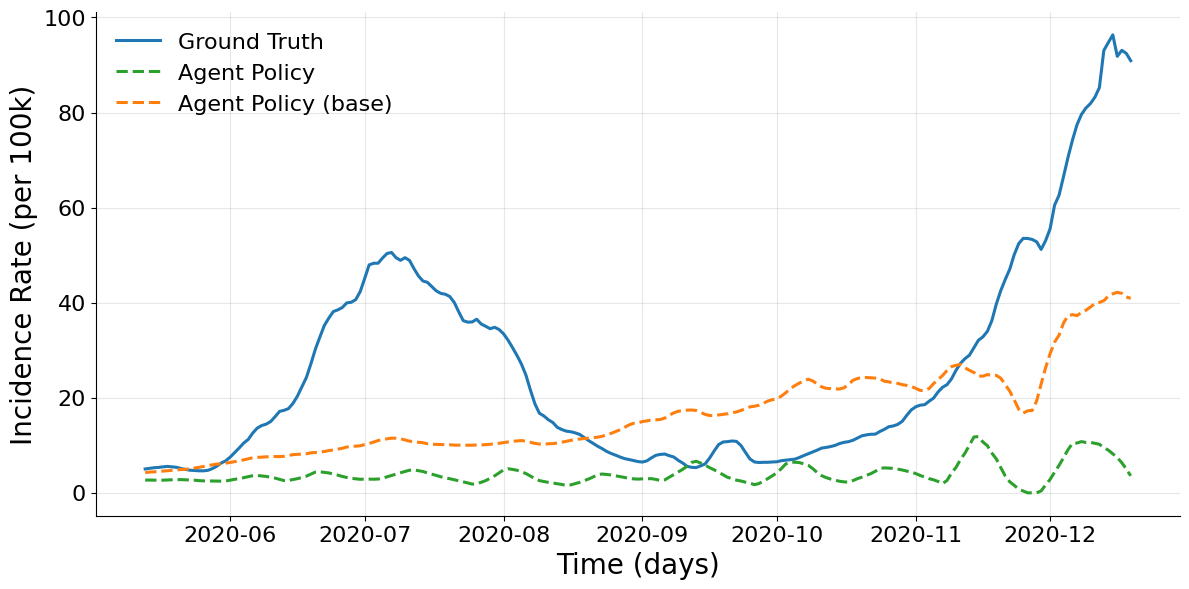

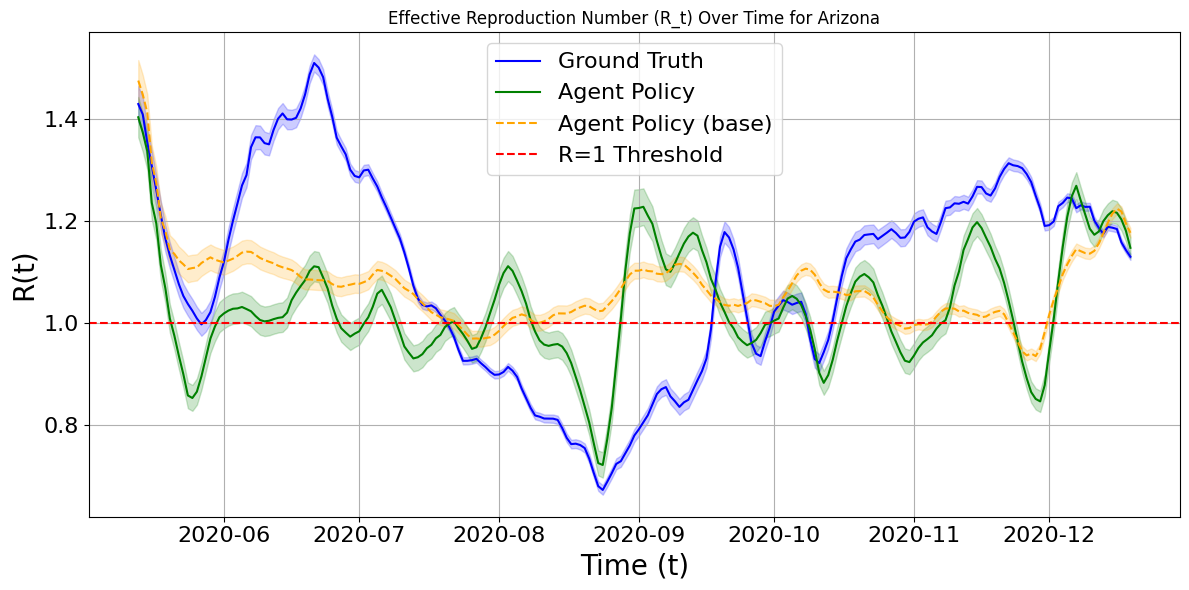

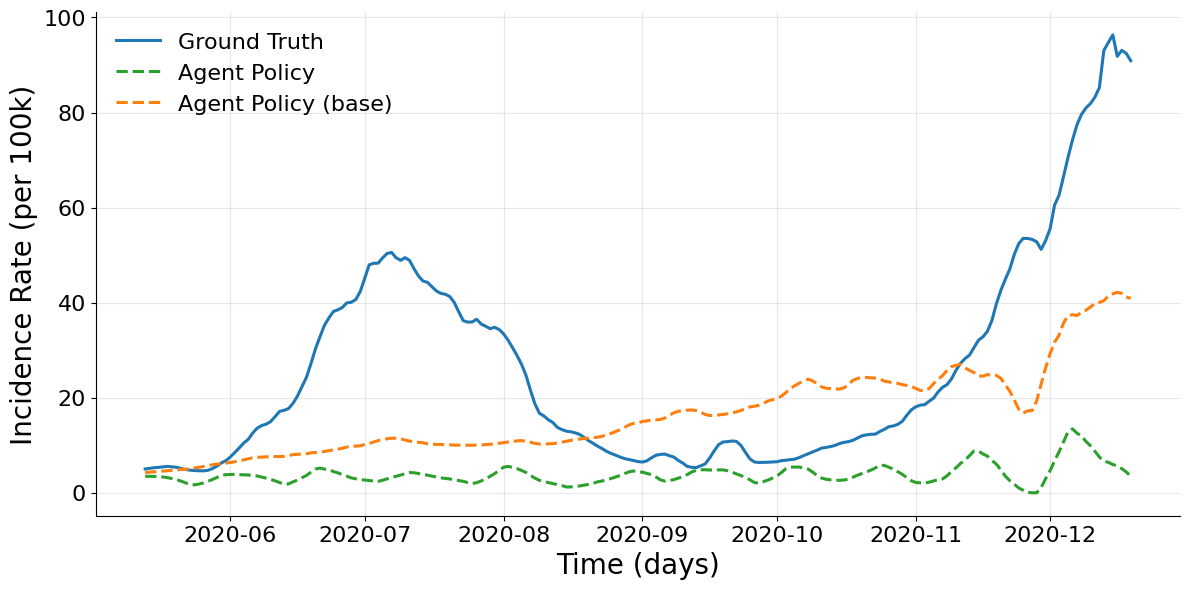

In [47]:
import os

import matplotlib.pyplot as plt

data_folder = 'outputs/baseline/results/'
suffix = 'results.csv'
data_paths = {state: f"{data_folder}{state.replace(' ', '_')}_{suffix}" for state in state_list}
state = state_list[0]
data_path = data_paths[state]
gt_df = pd.read_csv(data_path)
cols = ['Q_gt', 'D_gt', 'R_gt']
output_folder = "D:\\Code\\OD-COVID\\figures\\R0\\"
delta_window = 21
warm_day = 10
rt_df, rt_incidence = estimate_Rt(gt_df.iloc[warm_day:], cols = cols, window=delta_window, pop = pop_list[state])
### read policy data for plotting
# List all subfolders in the specified folder
results_folder = 'outputs\\3 weeks\\'
subfolders = [f.path for f in os.scandir(results_folder) if f.is_dir()]
for f in subfolders:
    results_path = os.path.join(f, 'results')
    agent_df = pd.read_csv(f"{results_path}\\{state.replace(' ', '_')}_results.csv")
    ra_df, ra_incidence = estimate_Rt(agent_df.iloc[warm_day:], cols = ['Q_pred', 'D_pred', 'R_pred'], window=delta_window, pop=pop_list[state])
    ra_base_df, ra_base_incidence = estimate_Rt(gt_df.iloc[warm_day:], cols = ['Q_pred', 'D_pred', 'R_pred'], window=delta_window, pop=pop_list[state])
    start_day = pd.to_datetime('2020-04-12')
    date = pd.date_range(start=start_day + pd.Timedelta(days=delta_window) + pd.Timedelta(days=warm_day), periods=len(rt_df))
    plot_Rt_and_incidence(rt_df, ra_df, rt_incidence, ra_incidence, date, delta_window, output_folder, state, [ra_base_df, ra_base_incidence])


In [118]:
import numpy as np
import pandas as pd
import textwrap
import matplotlib as mpl
from matplotlib.transforms import blended_transform_factory

def annotate_policies_topline(ax,
                              date_I,
                              df_policy,
                              label_col='Policy',
                              draw_vlines=True,
                              vline_color='#4d4d4d',
                              vline_alpha=0.4,
                              vline_style=(0,(4,2)),   # 深灰细虚线
                              fontsize=12,
                              wrap_width=26,
                              top_start=0.93,          # 第一排距离顶部的位置（axes坐标）
                              row_gap=0.07,            # 行间距（axes坐标）
                              max_rows=3,              # 顶部最多几排
                              cluster_days=12,         # 日期很近时分多行
                              x_offset_pt=2            # 文字相对竖线的水平偏移（pt）
                              ):

    # 字体：Times New Roman（若系统无该字体则忽略）
    try:
        mpl.rcParams['font.family'] = 'Times New Roman'
    except Exception:
        pass

    if df_policy is None or len(df_policy) == 0 or len(date_I) == 0:
        return

    # 准备日期/标签
    dates  = pd.to_datetime(df_policy['Date'], errors='coerce', infer_datetime_format=True)
    labels = df_policy[label_col].astype(str).fillna('Policy')
    date_I_np = pd.to_datetime(date_I)
    # 映射到最近的 x 索引
    items = []
    for dt, lab in zip(dates, labels):
        if pd.isna(dt): 
            continue
        idx = int(np.argmin(np.abs(date_I_np - pd.to_datetime(dt))))
        items.append((idx, date_I_np[idx], str(lab)))
    if not items:
        return
    items.sort(key=lambda t: t[0])

    # 按时间聚类 -> 不同行
    groups, gid = [[items[0]]], 0
    for a, b in zip(items[:-1], items[1:]):
        if (b[1] - a[1]).days <= cluster_days:
            groups[gid].append(b)
        else:
            groups.append([b]); gid += 1

    # 顶部各行的 y（axes 坐标）
    lanes = [top_start - i*row_gap for i in range(max_rows)]
    lanes = [y for y in lanes if 0.05 < y < 0.98]
    if not lanes:
        lanes = [0.92]

    # 变换：x 用数据坐标，y 用 axes 坐标
    trans = blended_transform_factory(ax.transData, ax.transAxes)

    for gi, g in enumerate(groups):
        y_axes = lanes[gi % len(lanes)]
        # 同一组内部，轻微左右交替偏移，避免文本重叠
        for k, (idx, x, lab) in enumerate(g):
            # 竖线（可选）
            if draw_vlines:
                ax.axvline(x=x, color=vline_color, alpha=vline_alpha,
                           linestyle=vline_style, linewidth=1.0, zorder=0.1)

            # 水平微偏移（点）
            dx = x_offset_pt * (1 if (k % 2 == 0) else -1)
            # 文本
            txt = textwrap.fill(lab, width=wrap_width)
            ax.text(x, y_axes, txt,
                    transform=trans,  # x=data, y=axes
                    ha='left' if dx >= 0 else 'right',
                    va='center',
                    fontsize=fontsize,
                    bbox=dict(boxstyle='round,pad=0.25',
                              facecolor='white', edgecolor='none', alpha=0.8),
                    zorder=0.2)
            # 再画一个极短的上端“刻度”以呼应竖线（可选，极淡）
            ax.plot([x, x], [y_axes-0.015, y_axes+0.015],
                    transform=trans, color=vline_color, alpha=0.25, linewidth=0.8, zorder=0.2)


# anmotation

In [188]:
import numpy as np 
import pandas as pd
import textwrap
import matplotlib as mpl
from collections import defaultdict

def annotate_policies_on_incidence(ax,
                                   date_I,
                                   y_series,
                                   df_policy,
                                   label_col='Policy',
                                   line_color='#9e9e9e',
                                   line_alpha=0.35,
                                   point_size=50,
                                   fontsize=12,
                                   wrap_width=26,
                                   min_gap_axes=0.06,
                                   cluster_days=14,        # 同期聚类窗口（天）
                                   base_offset_pt=24,      # 基础上下偏移（点）
                                   tier_step_pt=10         # 同组阶梯式增加的额外偏移（点）
                                   ):
    # ---- 全局字体：Times New Roman ----
    try:
        mpl.rcParams['font.family'] = 'Times New Roman'
    except Exception:
        pass

    if df_policy is None or len(df_policy) == 0 or len(date_I) == 0:
        return

    # 解析政策与对齐到最近 x
    dates = pd.to_datetime(df_policy['Date'], errors='coerce', infer_datetime_format=True)
    labels = df_policy[label_col].astype(str).fillna('Policy')
    date_I_np = pd.to_datetime(date_I)

    items = []
    for dt, lab in zip(dates, labels):
        if pd.isna(dt):
            continue
        idx = int(np.argmin(np.abs(date_I_np - pd.to_datetime(dt))))
        x = date_I_np[idx]
        y = float(y_series[idx])
        items.append((idx, x, y, lab))
    if not items:
        return

    # 竖线：深灰虚线，置底
    for _, x, _, _ in items:
        ax.axvline(x=x, color='#4d4d4d', alpha=line_alpha, linestyle='--', linewidth=1.0, zorder=0.1)

    # 分组：把相近日期（±cluster_days）聚成一组，组内做阶梯式错位
    items = sorted(items, key=lambda t: t[0])
    groups = defaultdict(list)
    g_id = 0
    groups[g_id].append(items[0])
    for prev, cur in zip(items[:-1], items[1:]):
        if (cur[1] - prev[1]).days <= cluster_days:
            groups[g_id].append(cur)
        else:
            g_id += 1
            groups[g_id].append(cur)

    # y 轴归一化，判断该点相对高度
    y_min, y_max = ax.get_ylim()
    denom = (y_max - y_min) if (y_max > y_min) else 1.0

    # 绘制：组内上下通道 + 阶梯偏移 + 左右交替
    for gid in sorted(groups.keys()):
        group = groups[gid]
        # 组内按 x 排序
        group = sorted(group, key=lambda t: t[1])

        # 计算每个标注的“上/下”方向：高于中位就往下放，低于中位就往上放
        dirs = []  # +1 表示上方，-1 表示下方
        for (idx, x, y, lab) in group:
            y_norm = (y - y_min) / denom
            dirs.append(+1 if y_norm < 0.5 else -1)

        # 组内依次阶梯化增加垂直偏移，左右交替水平偏移
        for k, ((idx, x, y, lab), sign) in enumerate(zip(group, dirs)):
            # 垂直偏移：基础 + 阶梯
            dy_pt = sign * (base_offset_pt + k * tier_step_pt)

            # 水平偏移：左右交替，拥挤时适度增加
            dx_pt = (12 + 2 * k) * (1 if (k % 2 == 0) else -1)

            # 文本换行
            lab_wrapped = textwrap.fill(lab, width=wrap_width)

            # 点（置底，避免遮挡）
            ax.scatter([x], [y], s=point_size, color='k', alpha=0.8, zorder=0.2)

            # 注释（置底；box更轻薄；箭头细线）
            ax.annotate(
                lab_wrapped,
                xy=(x, y),
                xycoords='data',
                xytext=(dx_pt, dy_pt),
                textcoords='offset points',
                ha='left' if dx_pt > 0 else 'right',
                va='center',
                fontsize=fontsize,
                bbox=dict(boxstyle='round,pad=0.25', facecolor='white', edgecolor='none', alpha=0.7),
                arrowprops=dict(arrowstyle='-', color='#4d4d4d', lw=1.0, alpha=0.85,
                                shrinkA=0, shrinkB=4, connectionstyle='angle3,angleA=0,angleB=90'),
                zorder=0.2,
                clip_on=False
            )

In [251]:
import numpy as np
import pandas as pd
import textwrap
import matplotlib as mpl
from collections import defaultdict

def annotate_policies_on_incidence2(ax,
                                   date_I,
                                   y_series,
                                   df_policy,
                                   label_col='Policy',
                                   line_color='#9e9e9e',
                                   line_alpha=0.35,
                                   point_size=50,
                                   fontsize=12,
                                   wrap_width=26,
                                   min_gap_axes=0.06,
                                   cluster_days=14,        # 同期聚类窗口（天）
                                   base_offset_pt=24,      # 基础偏移（点）
                                   tier_step_pt=10,        # 组内阶梯再上移（点）
                                   # ---- 新增几个稳健参数（可不改） ----
                                   extra_step_pt=6,        # 冲突时额外抬高步长（点）
                                   max_tiers=6,            # 每点最多尝试的“层数”
                                   side_step_pt=6,         # 冲突时水平微移步长（点）
                                   max_side_steps=2,       # 每层最多水平尝试次数
                                   bbox_expand=(1.05,1.10),# bbox放大系数(宽,高)，更稳健
                                   margin_px=4             # 与轴边界的安全像素边距
                                   ):
    # ---- 全局字体：Times New Roman ----
    try:
        mpl.rcParams['font.family'] = 'Times New Roman'
    except Exception:
        pass

    if df_policy is None or len(df_policy) == 0 or len(date_I) == 0:
        return

    # 解析政策与对齐到最近 x
    dates  = pd.to_datetime(df_policy['Date'], errors='coerce', infer_datetime_format=True)
    labels = df_policy[label_col].astype(str).fillna('Policy')
    date_I_np = pd.to_datetime(date_I)

    items = []
    for dt, lab in zip(dates, labels):
        if pd.isna(dt):
            continue
        idx = int(np.argmin(np.abs(date_I_np - pd.to_datetime(dt))))
        x = date_I_np[idx]
        y = float(y_series[idx])
        items.append((idx, x, y, lab))
    if not items:
        return

    # 竖线：深灰虚线，置底
    for _, x, _, _ in items:
        ax.axvline(x=x, color='#4d4d4d', alpha=line_alpha, linestyle='--', linewidth=1.0, zorder=0.1)

    # 分组：把相近日期（±cluster_days）聚成一组，组内做阶梯式错位
    items = sorted(items, key=lambda t: t[0])
    groups = defaultdict(list)
    g_id = 0
    groups[g_id].append(items[0])
    for prev, cur in zip(items[:-1], items[1:]):
        if (cur[1] - prev[1]).days <= cluster_days:
            groups[g_id].append(cur)
        else:
            g_id += 1
            groups[g_id].append(cur)

    # 渲染器与轴的像素边界
    fig = ax.figure
    if not fig.canvas:
        fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    ax_x0, ax_y0 = ax.transAxes.transform((0, 0))
    ax_x1, ax_y1 = ax.transAxes.transform((1, 1))

    # 已放置注释的 bbox（像素坐标）
    placed_bboxes = []

    def _overlap(b1, b2):
        x0 = max(b1.x0, b2.x0); x1 = min(b1.x1, b2.x1)
        y0 = max(b1.y0, b2.y0); y1 = min(b1.y1, b2.y1)
        return (x1 > x0) and (y1 > y0)

    def _collide(bb):
        return any(_overlap(bb, b) for b in placed_bboxes)

    # 上下边界判断：点太靠近顶部，则优先往下放
    y_min, y_max = ax.get_ylim()
    y_span = max(y_max - y_min, 1e-9)
    def prefer_up(y):
        y_norm = (y - y_min) / y_span
        return y_norm < 0.85  # 高于 ~85% 就优先向下

    # 绘制：优先向上；若越界或碰撞则抬高/微移；顶端则向下
    for gid in sorted(groups.keys()):
        group = sorted(groups[gid], key=lambda t: t[1])
        for k, (idx, x, y, lab) in enumerate(group):
            # 点（置底）
            ax.scatter([x], [y], s=point_size, color='k', alpha=0.85, zorder=0.2)

            # 初始偏移（向上为正；若靠近上边界则向下）
            sign = +1 if prefer_up(y) else -1
            base_dy = sign * (base_offset_pt + k * tier_step_pt)

            text_ok = False
            lab_wrapped = textwrap.fill(lab, width=wrap_width)

            for tier in range(max_tiers):
                dy_pt = base_dy + sign * (tier * extra_step_pt)
                # 水平微移候选（0, +, -）
                dx_candidates = [0]
                for s in range(1, max_side_steps + 1):
                    dx_candidates += [s * side_step_pt, -s * side_step_pt]

                for dx_pt in dx_candidates:
                    ann = ax.annotate(
                        lab_wrapped,
                        xy=(x, y),
                        xycoords='data',
                        xytext=(dx_pt, dy_pt),
                        textcoords='offset points',
                        ha='center',
                        va='bottom' if sign > 0 else 'top',
                        fontsize=fontsize,
                        bbox=dict(boxstyle='round,pad=0.25',
                                  facecolor='white', edgecolor='none', alpha=0.8),
                        arrowprops=dict(arrowstyle='-',
                                        color='#4d4d4d', lw=1.0, alpha=0.85,
                                        shrinkA=0, shrinkB=4,
                                        connectionstyle='angle3,angleA=0,angleB=90'),
                        zorder=0.2,
                        clip_on=False
                    )
                    # bbox 与边界/碰撞检测
                    fig.canvas.draw()
                    bb = ann.get_window_extent(renderer=renderer).expanded(bbox_expand[0], bbox_expand[1])

                    out_left  = (bb.x0 < ax_x0 + margin_px)
                    out_right = (bb.x1 > ax_x1 - margin_px)
                    out_top   = (bb.y1 > ax_y1 - margin_px)
                    out_bot   = (bb.y0 < ax_y0 + margin_px)

                    if out_left or out_right or out_top or out_bot or _collide(bb):
                        ann.remove()
                        continue
                    else:
                        placed_bboxes.append(bb)
                        text_ok = True
                        break
                if text_ok:
                    break
            # 若全部尝试失败：保留点与竖线，不放文字，避免越界/拥挤
            # 直接进入下一条


# 添加误差范围线

In [252]:
import numpy as np
import matplotlib.pyplot as plt

def _stack_series_list(series_list, trim_left=0):
    arrs = []
    for s in series_list:
        a = np.asarray(s)
        if trim_left > 0:
            a = a[trim_left:]
        arrs.append(a)
    min_len = min(len(a) for a in arrs)
    arrs = [a[:min_len] for a in arrs]
    return np.vstack(arrs)  # (n_runs, n_time)

def plot_Rt_and_incidence_with_std(
    rt_df,
    ra_df_list,                # 多次运行的 R(t) DataFrame 列表，但R绘图仅用第一个
    rt_incidence,
    ra_incidence_list,         # 多次运行的 incidence 序列列表 -> 均值±std 阴影
    date,
    delta_window,
    output_folder=None,
    state='state',
    base_results=None,         # [ra_base_df_list, ra_base_incidence_list]
    df_policy=None,
    value_band='std',          # 'std' 或 'sem95'=1.96*SEM
    clip_lower=0.0,
    policy_period=21
):
    assert len(ra_df_list) >= 1, "ra_df_list 至少包含一个 DataFrame"
    ra_df_first = ra_df_list[4].copy()

    # ---------- 1) 对齐长度 ----------
    # R(t) 的长度以 ra_df_first 为准（与 rt_df 取最短对齐）
    n_time_R = min(len(ra_df_first), len(rt_df))
    date_R = np.asarray(date)[:n_time_R]

    # incidence 的长度来自 ra_incidence_list（左裁剪 delta_window 后的最短长度）
    Inc_stack = _stack_series_list(ra_incidence_list, trim_left=0)
    n_time_I = Inc_stack.shape[1]
    # date_I = np.asarray(date)[:n_time_I]
    start_day = pd.to_datetime('2020-04-12')
    end_day = pd.to_datetime('2020-12-19')
    policy_date = pd.date_range(start=start_day, end=end_day, freq=f'{policy_period}D')
    date_I = pd.to_datetime(pd.Index.union(
            pd.date_range(end=date[0] - pd.Timedelta(days=1), periods=delta_window, freq='D'),
            date
        ))
    delta = (policy_date[1] - date_I[0]).days
    hightlight_indices = date_I[delta::policy_period]

    rt_incidence_trim = np.asarray(rt_incidence)[0:][:n_time_I]

    # Ground Truth R
    rt_mean = rt_df['R_mean'].to_numpy()[:n_time_R]
    rt_low  = rt_df['R_low'].to_numpy()[:n_time_R]  if 'R_low'  in rt_df else None
    rt_high = rt_df['R_high'].to_numpy()[:n_time_R] if 'R_high' in rt_df else None

    # Agent R（仅用第一个）
    ra_R_mean = ra_df_first['R_mean'].to_numpy()[:n_time_R]
    ra_R_low  = ra_df_first['R_low'].to_numpy()[:n_time_R]  if 'R_low'  in ra_df_first else None
    ra_R_high = ra_df_first['R_high'].to_numpy()[:n_time_R] if 'R_high' in ra_df_first else None

    # ---------- 2) incidence 均值与误差带 ----------
    def _mean_and_band(stack):
        mean = stack.mean(axis=0)
        if value_band == 'sem95':
            band = 10 * (stack.std(axis=0, ddof=1) / np.sqrt(stack.shape[0]))
        else:
            band = 2 * stack.std(axis=0, ddof=1)
        lower = mean - band
        upper = mean + band
        if clip_lower is not None:
            lower = np.maximum(lower, clip_lower)
        return mean, lower, upper

    ra_I_mean, ra_I_low, ra_I_high = _mean_and_band(Inc_stack)

    # ---------- 3) base（可选） ----------
    has_base = False
    if base_results:
        ra_base_df_list, ra_base_incidence_list = base_results
        if len(ra_base_df_list) >= 1 and len(ra_base_incidence_list) >= 1:
            has_base = True
            base_df_first = ra_base_df_list[0].copy()
            # R(t) base（同样仅用第一个）
            base_R_mean = base_df_first['R_mean'].to_numpy()[:n_time_R]
            base_R_low  = base_df_first['R_low'].to_numpy()[:n_time_R]  if 'R_low'  in base_df_first else None
            base_R_high = base_df_first['R_high'].to_numpy()[:n_time_R] if 'R_high' in base_df_first else None
            # incidence base（做聚合）
            BaseInc_stack = _stack_series_list(ra_base_incidence_list, trim_left=0)
            # 与主曲线按最短对齐
            n_time_I = min(n_time_I, BaseInc_stack.shape[1])
            date_I = date_I[:n_time_I]
            # 裁切主曲线与gt
            ra_I_mean, ra_I_low, ra_I_high = ra_I_mean[:n_time_I], ra_I_low[:n_time_I], ra_I_high[:n_time_I]
            rt_incidence_trim = rt_incidence_trim[:n_time_I]
            base_I_mean, base_I_low, base_I_high = _mean_and_band(BaseInc_stack[:, :n_time_I])
        else:
            base_df_first = None

    # ---------- 4) 画 R(t)：仅用第一个 run ----------
    plt.figure(figsize=(12, 6))
    # Ground Truth
    plt.plot(date_R, rt_mean, label='Ground Truth', color='blue', linewidth=2.0)
    if rt_low is not None and rt_high is not None:
        plt.fill_between(date_R, rt_low, rt_high, color='blue', alpha=0.2)

    # Agent（第一个）
    plt.plot(date_R, ra_R_mean, label='Agent Policy', color='green', linewidth=2.0)
    if ra_R_low is not None and ra_R_high is not None:
        plt.fill_between(date_R, ra_R_low, ra_R_high, color='green', alpha=0.2)

    # Base（第一个，可选）
    if has_base:
        plt.plot(date_R, base_R_mean, label='Agent Policy (base)', color='orange', linestyle='--', linewidth=2.0)
        if base_R_low is not None and base_R_high is not None:
            plt.fill_between(date_R, base_R_low, base_R_high, color='orange', alpha=0.18)

    plt.axhline(1, color='red', linestyle='--', label='R=1 Threshold', linewidth=1.6)
    plt.xlabel('Time (t)', fontsize=20)
    plt.ylabel('R(t)', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('Effective Reproduction Number (R_t) Over Time for ' + state.title())
    plt.legend(fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if output_folder:
        plt.savefig(f"{output_folder}/{state.replace(' ', '_')}_R0.png", dpi=200)
    plt.show()


    
    # ---------- 5) 画 Incidence（多次实验的均值±误差带） ----------
    plt.figure(figsize=(12, 6))
    # Ground Truth
    plt.plot(date_I, rt_incidence_trim, label='Ground Truth', color='#1f77b4', linewidth=2.2)
    # Agent 聚合
    plt.plot(date_I, ra_I_mean, label='Agent Policy', color='#2ca02c', linewidth=2.2, linestyle='--')
    plt.fill_between(date_I, ra_I_low, ra_I_high, color='#2ca02c', alpha=0.18)
    # Base 聚合（可选）
    if has_base:
        plt.plot(date_I, base_I_mean, label='Agent Policy (base)', color='#ff7f0e', linewidth=2.0, linestyle='--')
        plt.fill_between(date_I, base_I_low, base_I_high, color='#ff7f0e', alpha=0.18)

    plt.xlabel('Time (days)', fontsize=20)
    plt.ylabel('Incidence Rate (per 100k)', fontsize=20)
    plt.legend(frameon=False, fontsize=14, loc='upper left')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax = plt.gca()
    if df_policy is not None and len(df_policy) > 0:
        annotate_policies_on_incidence2(ax=ax,
                                       date_I=date_I,
                                       y_series=rt_incidence_trim,
                                       df_policy=df_policy,
                                       label_col='Policy')

        ax.scatter(hightlight_indices, ra_I_mean[delta::policy_period], color='green', s=50, zorder=3)

    plt.grid(alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if output_folder:
        plt.savefig(f"{output_folder}/{state}_incidence.png", dpi=200)
    plt.show()
    return


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _ensure_list(x):
    return x if isinstance(x, (list, tuple)) else [x]

def _band_from_list(series_list):
    """
    假定每个序列长度一致（你已有保证），返回 (mean, low, high)
    这里用均值±标准差；如需95%CI可换成 1.96*std/√n
    """
    M = np.vstack(series_list)            # (n_runs, T)
    mean = M.mean(axis=0)
    scale = 5
    std  = M.std(axis=0, ddof=1) if M.shape[0] > 1 else np.zeros_like(mean)
    low, high = mean - std * scale, mean + std * scale
    return mean, low, high

# ===================== Active cases =====================
def plot_active_cases_std(
    gt_df,
    agent_df,                    # DataFrame 或 list[DataFrame]
    date,
    delta_window,
    output_folder=None,
    state='state',
    base_results=None            # [gt_df_base, agent_base_df] 或 [gt_df_base, agent_base_df_list]
):
    plt.figure(figsize=(12, 6))
    # --- GT ---
    gt_df = gt_df.copy()
    gt_df['active_case_ratio'] = gt_df['Q_gt'] / pop_list[state] * 100000
    gt_y = gt_df['active_case_ratio'].to_numpy()

    # --- Agent（支持 list）---
    agent_list = _ensure_list(agent_df)
    # 1) 作为“主线”的 run：沿用你的逻辑——用第一个元素
    agent_first = agent_list[0].copy()
    agent_first['active_case_ratio'] = agent_first['Q_pred'] / pop_list[state] * 100000
    agent_line = agent_first['active_case_ratio'].to_numpy()

    # 2) 若传入 list，额外计算阴影
    show_band = len(agent_list) > 1
    if show_band:
        series_list = []
        for df in agent_list:
            df = df.copy()
            df['active_case_ratio'] = df['Q_pred'] / pop_list[state] * 100000
            series_list.append(df['active_case_ratio'].to_numpy())
        mean_band, low_band, high_band = _band_from_list(series_list)

    # --- Base（保持你原逻辑：只画线；不做阴影）---
    base_line = None
    if base_results:
        base_df_or_list, _ = base_results
        base_first = _ensure_list(base_df_or_list)[0].copy()
        base_first['active_case_ratio'] = base_first['Q_pred'] / pop_list[state] * 100000
        base_line = base_first['active_case_ratio'].to_numpy()

    # --- 绘图（沿用你的索引与裁剪方式）---
    sl = slice(delta_window, None)
    plt.plot(date, gt_y[sl],           label='Ground Truth',   color='blue', linewidth=2)
    plt.plot(date, agent_line[sl],     label='Agent Policy',   color='green', linestyle='--', linewidth=2)
    if show_band:
        plt.fill_between(date, low_band[sl], high_band[sl], color='green', alpha=0.18)
    if base_line is not None:
        plt.plot(date, base_line[sl],  label='Agent Policy (base)', color='orange', linestyle='--', linewidth=2)

    plt.xlabel('Time (days)', fontsize=20)
    plt.ylabel('Active case ratio (per 100K)', fontsize=20)
    plt.title('Active Case Ratio of ' + state + ' Over Time', fontsize=22)
    plt.legend(fontsize=16, frameon=False)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.grid(alpha=0.3)
    ax = plt.gca(); ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if output_folder:
        plt.savefig(f"{output_folder}/{state.replace(' ', '_')}_active_cases.png")
    plt.show()
    return gt_df, (agent_list[0] if isinstance(agent_df, (list, tuple)) else agent_df)

# ===================== Death incidence (7-day mean) =====================
def plot_death_cases_std(
    gt_df,
    agent_df,                    # DataFrame 或 list[DataFrame]
    date,
    delta_window,
    output_folder=None,
    state='state',
    base_results=None            # [gt_df_base, agent_base_df] 或 [gt_df_base, agent_base_df_list]
):
    # --- GT ---
    gt_df = gt_df.copy()
    gt_df['new_deaths'] = gt_df['D_gt'].diff().clip(lower=0)
    gt_df['death_incidence_per100k'] = gt_df['new_deaths'] / pop_list[state] * 100000
    gt_df['death_incidence_7d'] = gt_df['death_incidence_per100k'].rolling(7, min_periods=1).mean()
    gt_y = gt_df['death_incidence_7d'].to_numpy()

    # --- Agent（支持 list）---
    agent_list = _ensure_list(agent_df)
    # 主线：第一个元素
    af = agent_list[0].copy()
    af['new_deaths'] = af['D_pred'].diff().clip(lower=0)
    af['death_incidence_per100k'] = af['new_deaths'] / pop_list[state] * 100000
    af['death_incidence_7d'] = af['death_incidence_per100k'].rolling(7, min_periods=1).mean()
    agent_line = af['death_incidence_7d'].to_numpy()

    # 阴影
    show_band = len(agent_list) > 1
    if show_band:
        series_list = []
        for df in agent_list:
            df = df.copy()
            df['new_deaths'] = df['D_pred'].diff().clip(lower=0)
            df['death_incidence_per100k'] = df['new_deaths'] / pop_list[state] * 100000
            df['death_incidence_7d'] = df['death_incidence_per100k'].rolling(7, min_periods=1).mean()
            series_list.append(df['death_incidence_7d'].to_numpy())
        mean_band, low_band, high_band = _band_from_list(series_list)

    # --- Base（只画线）---
    base_line = None
    if base_results:
        base_df_or_list, _ = base_results
        bf = _ensure_list(base_df_or_list)[0].copy()
        bf['new_deaths'] = bf['D_pred'].diff().clip(lower=0)
        bf['death_incidence_per100k'] = bf['new_deaths'] / pop_list[state] * 100000
        bf['death_incidence_7d'] = bf['death_incidence_per100k'].rolling(7, min_periods=1).mean()
        base_line = bf['death_incidence_7d'].to_numpy()

    # --- 绘图（沿用你的索引与裁剪方式）---
    plt.figure(figsize=(12, 6))
    sl = slice(delta_window, None)
    plt.plot(date, gt_y[sl],          label='Ground Truth', color='blue', linewidth=2)
    plt.plot(date, agent_line[sl],    label='Agent Policy', color='green', linestyle='--', linewidth=2)
    if show_band:
        plt.fill_between(date, low_band[sl], high_band[sl], color='green', alpha=0.18)
    if base_line is not None:
        plt.plot(date, base_line[sl], label='Agent Policy (base)', color='orange', linestyle='--', linewidth=2)

    plt.xlabel('Time (days)', fontsize=20)
    plt.ylabel('Daily Death Incidence (per 100K)', fontsize=20)
    plt.title('Daily Death Incidence of ' + state + ' Over Time', fontsize=22)
    plt.legend(fontsize=16, frameon=False)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.grid(alpha=0.3)
    ax = plt.gca(); ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if output_folder:
        plt.savefig(f"{output_folder}/{state.replace(' ', '_')}_death_case_ratio.png")
    plt.show()
    return gt_df, (agent_list[0] if isinstance(agent_df, (list, tuple)) else agent_df)


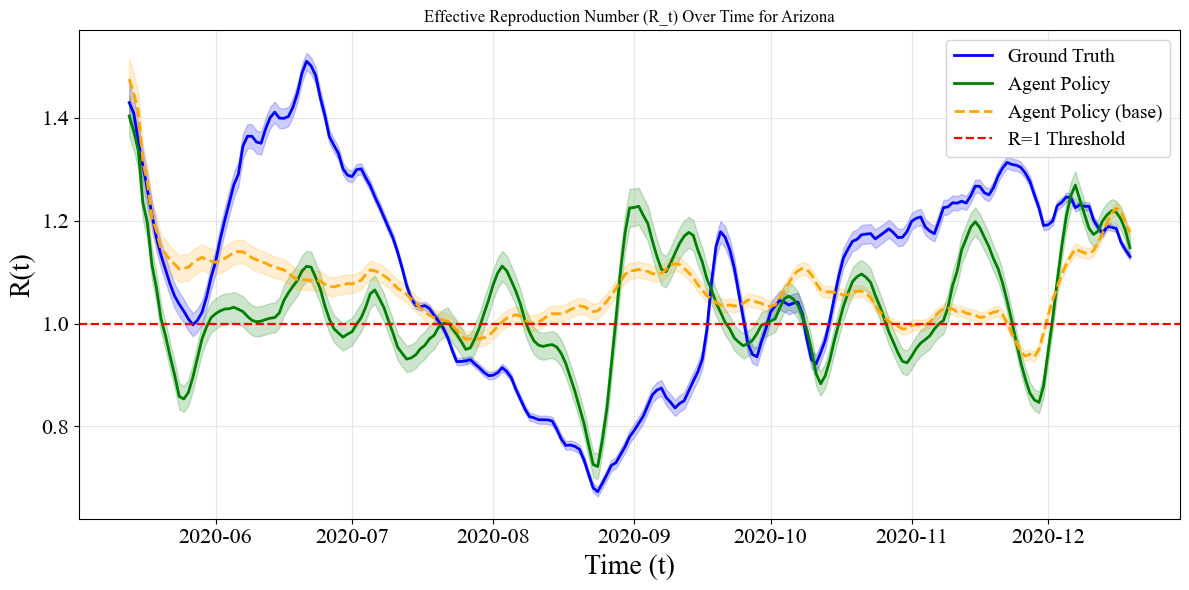

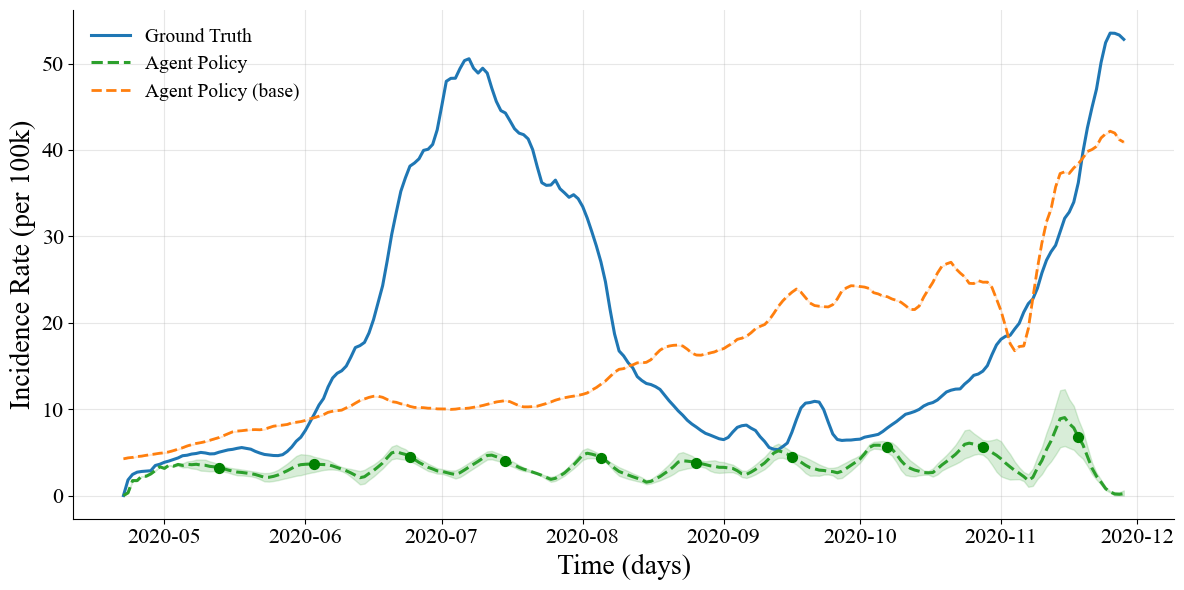

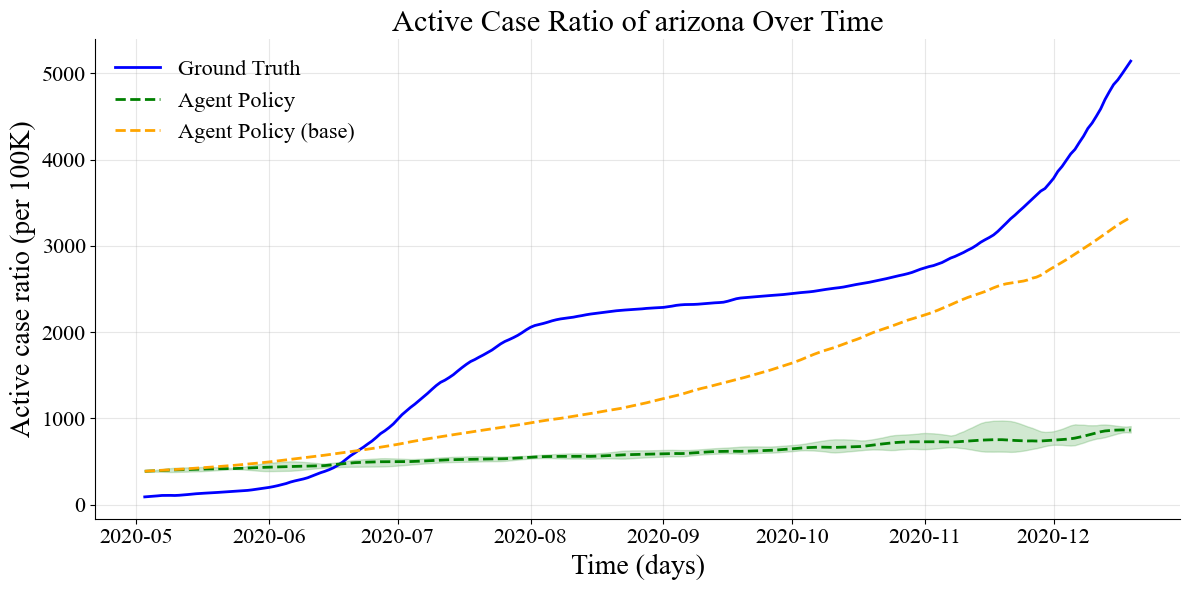

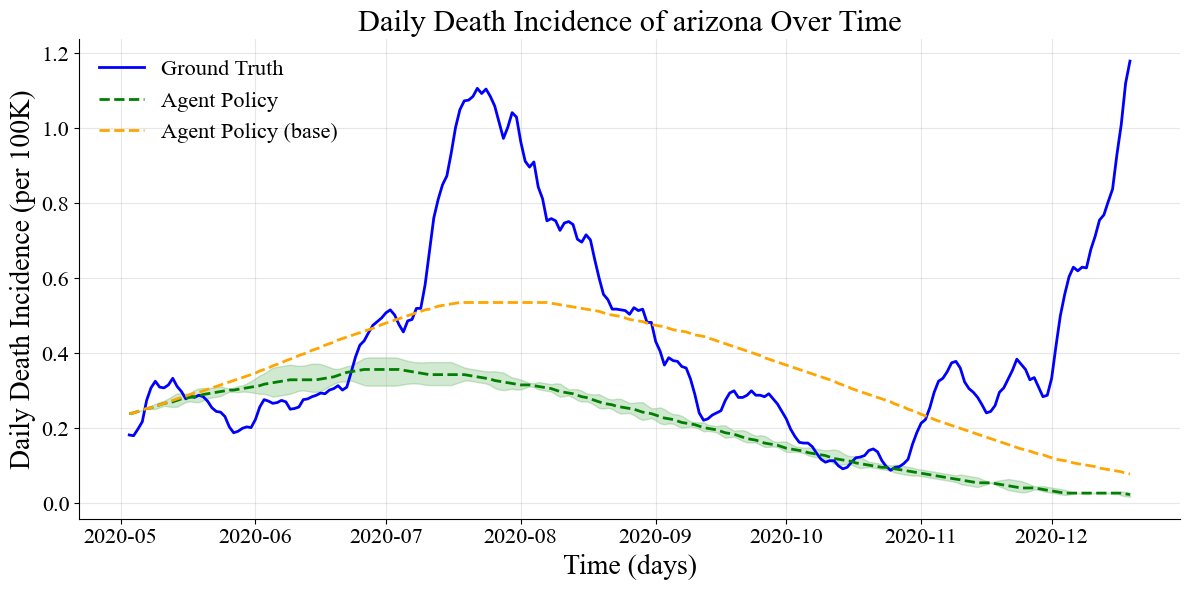

In [209]:
import os

import matplotlib.pyplot as plt

data_folder = 'outputs/baseline/results/'
suffix = 'results.csv'
data_paths = {state: f"{data_folder}{state.replace(' ', '_')}_{suffix}" for state in state_list}
state = state_list[0]
data_path = data_paths[state]
gt_df = pd.read_csv(data_path)
cols = ['Q_gt', 'D_gt', 'R_gt']
output_folder = "D:\\Code\\OD-COVID\\figures\\R0\\"
delta_window = 21
warm_day = 10
rt_df, rt_incidence = estimate_Rt(gt_df.iloc[warm_day:], cols = cols, window=delta_window, pop = pop_list[state])
### read policy data for plotting
# List all subfolders in the specified folder
results_folder = 'outputs\\3 weeks\\'
subfolders = [f.path for f in os.scandir(results_folder) if f.is_dir()]
ra_df_list = []
ra_incidence_list = []
ra_base_df_list = []
ra_base_incidence_list = []
agent_df_list = []
for f in subfolders:
    results_path = os.path.join(f, 'results')
    agent_df = pd.read_csv(f"{results_path}\\{state.replace(' ', '_')}_results.csv")
    ra_df, ra_incidence = estimate_Rt(agent_df.iloc[warm_day:], cols = ['Q_pred', 'D_pred', 'R_pred'], window=delta_window, pop=pop_list[state])
    ra_base_df, ra_base_incidence = estimate_Rt(gt_df.iloc[warm_day:], cols = ['Q_pred', 'D_pred', 'R_pred'], window=delta_window, pop=pop_list[state])
    ra_df_list.append(ra_df)
    ra_incidence_list.append(ra_incidence)
    ra_base_df_list.append(ra_base_df)
    ra_base_incidence_list.append(ra_base_incidence)
    agent_df_list.append(agent_df)
start_day = pd.to_datetime('2020-04-12')
date = pd.date_range(start=start_day + pd.Timedelta(days=delta_window) + pd.Timedelta(days=warm_day), periods=len(rt_df))
plot_Rt_and_incidence_with_std(rt_df, ra_df_list, rt_incidence, ra_incidence_list, date, delta_window, output_folder, state, [ra_base_df_list, ra_base_incidence_list])
date = pd.date_range(start=start_day + pd.Timedelta(days=delta_window), periods=len(gt_df) - delta_window)
gt_df, agent_df = plot_active_cases_std(gt_df, agent_df_list, date, delta_window, output_folder, state, [gt_df, agent_df])
gt_df, agent_df = plot_death_cases_std(gt_df, agent_df_list, date, delta_window, output_folder, state, [gt_df, agent_df_list])

## 添加policy

Processing state: arizona


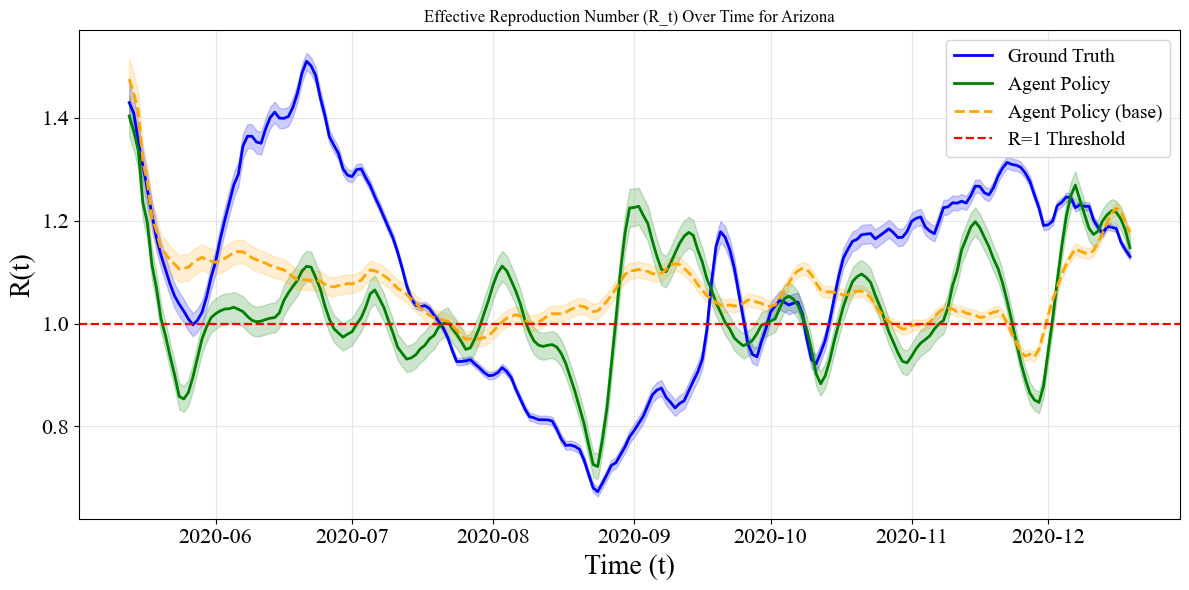

C:\Users\zshiay\AppData\Local\Temp\ipykernel_42728\419131490.py:39: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dates  = pd.to_datetime(df_policy['Date'], errors='coerce', infer_datetime_format=True)


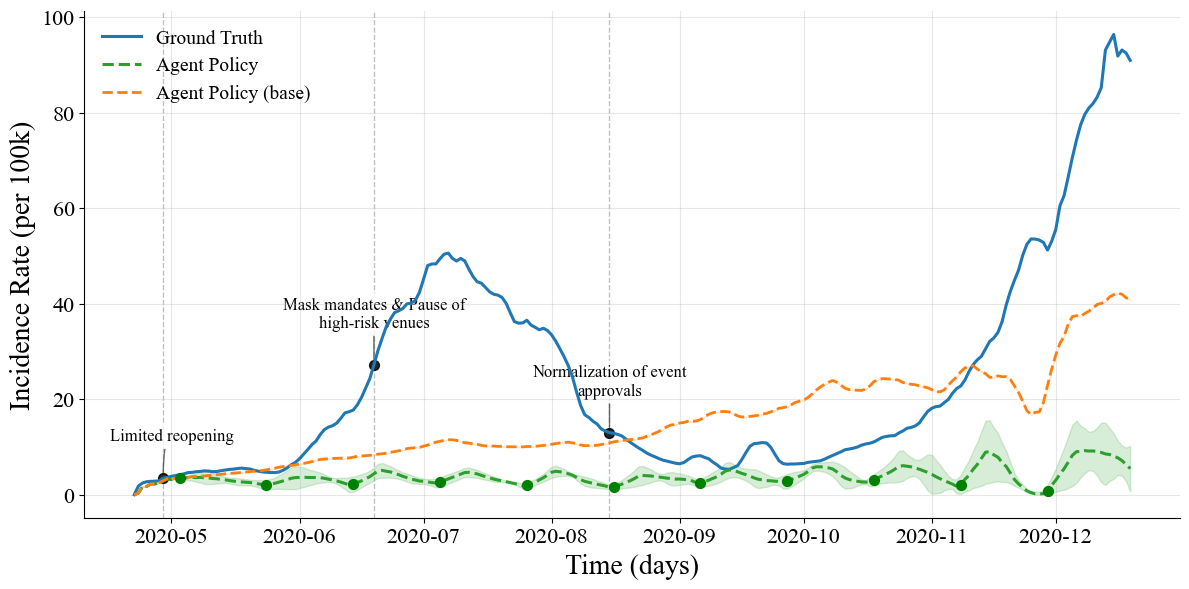

In [254]:
state = state_list[0]
print(f"Processing state: {state}")
df_policy = pd.read_csv('datasets/policy summarize/'+state+'_policies_2020_EN.csv')
data_folder = 'outputs/baseline/results/'
suffix = 'results.csv'
data_paths = {state: f"{data_folder}{state}_{suffix}" for state in state_list}
data_path = data_paths[state]
gt_df = pd.read_csv(data_path)
cols = ['Q_gt', 'D_gt', 'R_gt']
output_folder = "D:\\Code\\OD-COVID\\figures\\R0\\"
delta_window = 21
warm_day = 10
rt_df, rt_incidence = estimate_Rt(gt_df.iloc[warm_day:], cols = cols, window=delta_window, pop = pop_list[state])
### read policy data for plotting
# List all subfolders in the specified folder
results_folder = 'outputs\\3 weeks\\'
subfolders = [f.path for f in os.scandir(results_folder) if f.is_dir()]
ra_df_list = []
ra_incidence_list = []
ra_base_df_list = []
ra_base_incidence_list = []
agent_df_list = []
for f in subfolders:
    results_path = os.path.join(f, 'results')
    agent_df = pd.read_csv(f"{results_path}\\{state}_results.csv")
    ra_df, ra_incidence = estimate_Rt(agent_df.iloc[warm_day:], cols = ['Q_pred', 'D_pred', 'R_pred'], window=delta_window, pop=pop_list[state])
    ra_base_df, ra_base_incidence = estimate_Rt(gt_df.iloc[warm_day:], cols = ['Q_pred', 'D_pred', 'R_pred'], window=delta_window, pop=pop_list[state])
    ra_df_list.append(ra_df)
    ra_incidence_list.append(ra_incidence)
    ra_base_df_list.append(ra_base_df)
    ra_base_incidence_list.append(ra_base_incidence)
    agent_df_list.append(agent_df)
start_day = pd.to_datetime('2020-04-12')
date = pd.date_range(start=start_day + pd.Timedelta(days=delta_window) + pd.Timedelta(days=warm_day), periods=len(rt_df))
plot_Rt_and_incidence_with_std(rt_df, ra_df_list, rt_incidence, ra_incidence_list, date, delta_window, output_folder, state, [ra_base_df_list, ra_base_incidence_list], df_policy, policy_period=21)
#plot_Rt_and_incidence_with_std(rt_df, ra_df_list, rt_incidence, ra_incidence_list, date, delta_window, output_folder, state, [ra_base_df_list, ra_base_incidence_list], df_policy)

In [203]:
ra_incidence
rt_incidence
date
date_I = pd.to_datetime(pd.Index.union(
        pd.date_range(end=date[0] - pd.Timedelta(days=1), periods=delta_window, freq='D'),
        date
    ))
date_I

DatetimeIndex(['2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25',
               '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29',
               '2020-04-30', '2020-05-01',
               ...
               '2020-12-10', '2020-12-11', '2020-12-12', '2020-12-13',
               '2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17',
               '2020-12-18', '2020-12-19'],
              dtype='datetime64[ns]', length=242, freq='D')

In [200]:
end_day = pd.to_datetime('2020-12-19')
date_sequence = pd.date_range(start=start_day, end=end_day, freq='1D')
print(len(date_sequence))   


252


In [236]:
start_day = pd.to_datetime('2020-04-12')
end_day = pd.to_datetime('2020-12-19')
policy_date = pd.date_range(start=start_day, end=end_day, freq='21D')
date_I = pd.to_datetime(pd.Index.union(
        pd.date_range(end=date[0] - pd.Timedelta(days=1), periods=delta_window, freq='D'),
        date
    ))
delta = (policy_date[1] - date_I[0]).days
hightlight_indices = date_I[delta::21]
hightlight_indices 
delta 

11

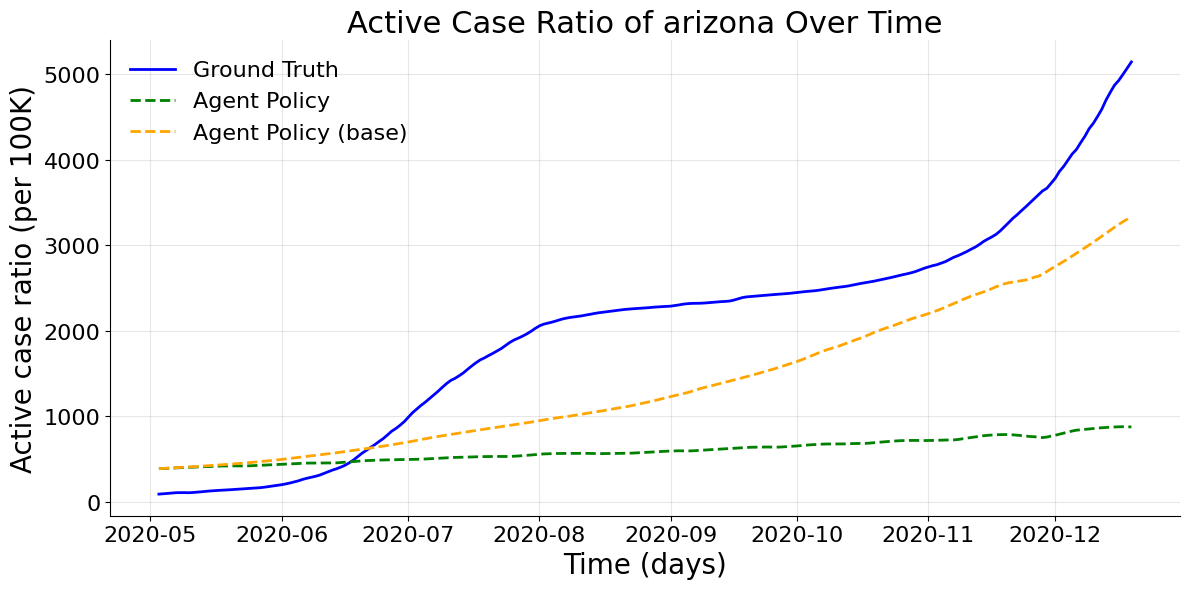

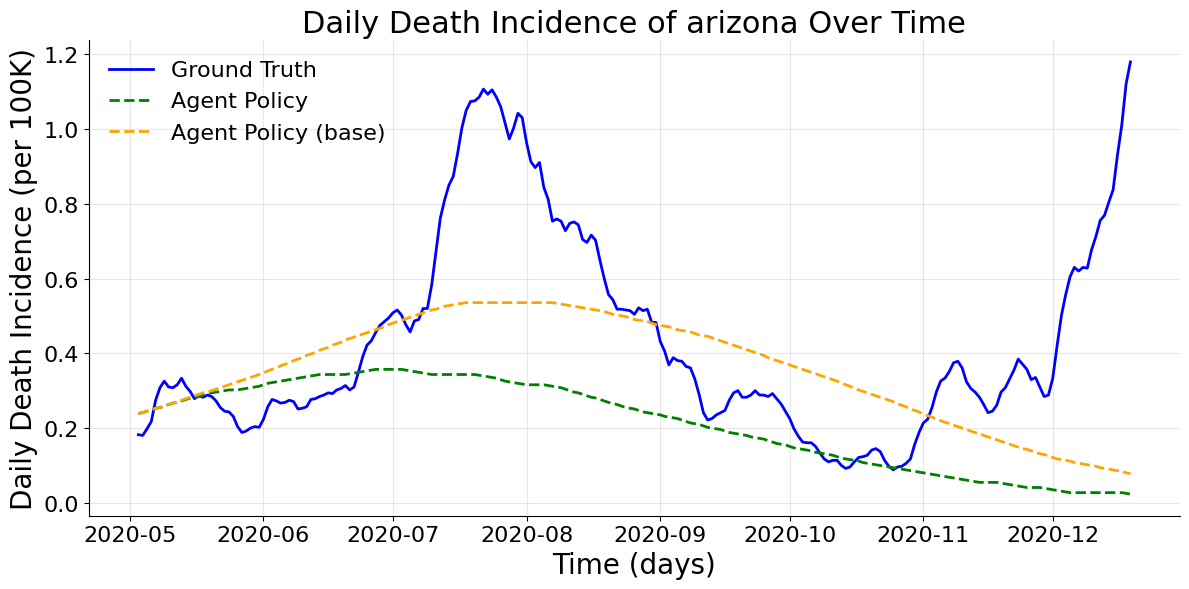

In [66]:
state = state_list[0]
data_path = data_paths[state]
gt_df = pd.read_csv(data_path)
agent_df = pd.read_csv(f"{results_path}\\{state.replace(' ', '_')}_results.csv")

gt_df['active_case_ratio'] = gt_df['Q_gt'] / pop_list[state] *100000
agent_df['active_case_ratio'] = agent_df['Q_pred'] / pop_list[state] * 100000
date = pd.date_range(start=start_day + pd.Timedelta(days=delta_window), periods=len(gt_df) - delta_window)
gt_df, agent_df = plot_active_cases(gt_df, agent_df, date, delta_window, output_folder, state, [gt_df, agent_df])
gt_df, agent_df = plot_death_cases(gt_df, agent_df, date, delta_window, output_folder, state, [gt_df, agent_df])

In [37]:
agent_active_cases_aver = agent_df['active_case_ratio'].dropna().mean()
agent_death_cases_aver = agent_df['death_incidence_per100k'].dropna().mean()
agent_ro_average = ra_df['R_mean'].dropna().mean()
agent_incidence_average = ra_incidence.dropna().mean()

gt_active_cases_aver = gt_df['active_case_ratio'].dropna().mean()
gt_death_cases_aver = gt_df['death_incidence_per100k'].dropna().mean()
gt_ro_average = rt_df['R_mean'].dropna().mean()
gt_incidence_average = rt_incidence.dropna().mean()

over_df = pd.DataFrame({
    'Metric': ['Average Active Cases per 100K', 'Average Daily Death Incidence per 100K', 'Average R0', 'Average Incidence Rate per 100K'],
    f'Ground Truth ({state})': [gt_active_cases_aver, gt_death_cases_aver, gt_ro_average, gt_incidence_average],
    f'Agent Policy ({state})': [agent_active_cases_aver, agent_death_cases_aver, agent_ro_average, agent_incidence_average]
})
over_df.round(3)

,Metric,Ground Truth (arizona),Agent Policy (arizona)
0,Average Active Cases per 100K,1847.032,588.936
1,Average Daily Death Incidence per 100K,0.426,0.215
2,Average R0,1.097,1.030
3,Average Incidence Rate per 100K,24.105,3.739


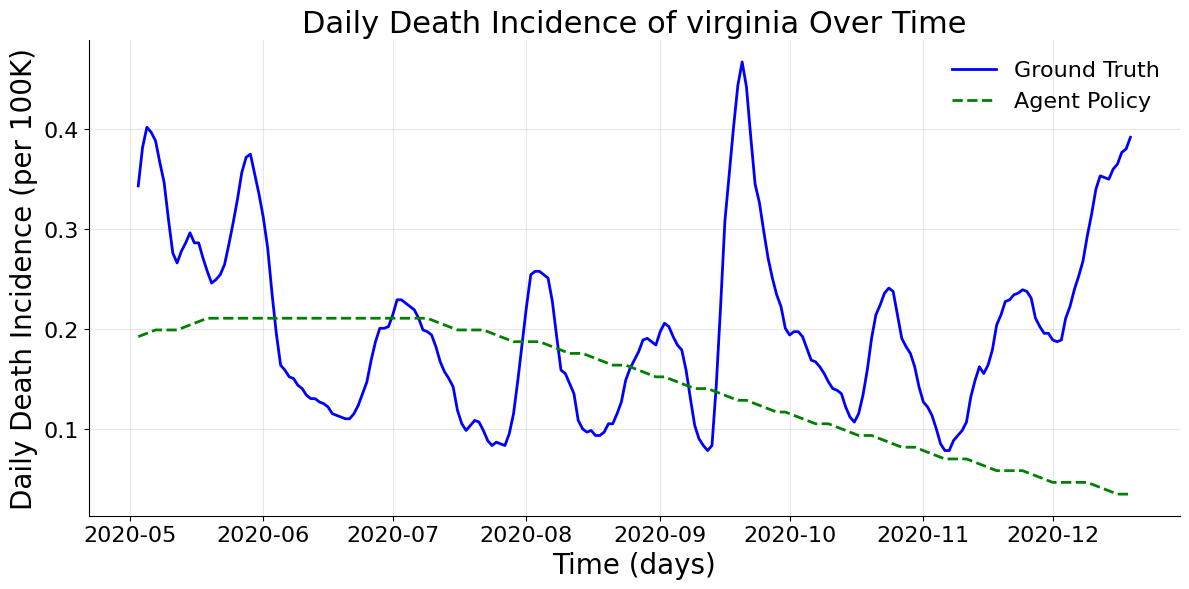

In [126]:

# gt_df['death_case_ratio'] = gt_df['D_gt'] / pop_list[state] * 100000
# agent_df['death_case_ratio'] = agent_df['D_pred'] / pop_list[state] * 100000
state = state_list[4]
data_path = data_paths[state]
gt_df = pd.read_csv(data_path)
agent_df = pd.read_csv(f"{results_path}\\{state.replace(' ', '_')}_results.csv")

gt_df['new_deaths'] = gt_df['D_gt'].diff().clip(lower=0)
gt_df['death_incidence_per100k'] = gt_df['new_deaths'] / pop_list[state] * 100_000
gt_df['death_incidence_7d'] = gt_df['death_incidence_per100k'].rolling(7, min_periods=1).mean()

agent_df['new_deaths'] = agent_df['D_pred'].diff().clip(lower=0)
agent_df['death_incidence_per100k'] = agent_df['new_deaths'] / pop_list[state] * 100000
agent_df['death_incidence_7d'] = agent_df['death_incidence_per100k'].rolling(7, min_periods=1).mean()
# 绘制 gt_df 的 death_case_ratio
plt.figure(figsize=(12, 6))
plt.plot(date, gt_df['death_incidence_7d'][delta_window:], label='Ground Truth', color='blue', linewidth=2)
# 绘制 agent_df 的 death_case_ratio
plt.plot(date, agent_df['death_incidence_7d'][delta_window:], label='Agent Policy', color='green', linestyle='--', linewidth=2)
# 添加图例、标题和标签
plt.xlabel('Time (days)', fontsize=20)
plt.ylabel('Daily Death Incidence (per 100K)', fontsize=20)
plt.title('Daily Death Incidence of ' + state + ' Over Time', fontsize=22)
plt.legend(fontsize=16, frameon=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# 美化图表
plt.grid(alpha=0.3)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(f"{output_folder}/{state.replace(' ', '_')}_death_case_ratio.png")
# 显示图表
plt.tight_layout()
plt.show()